In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pyemma
import deeptime as dt
import mdtraj as md
import networkx as nx
from timescales import implied_timescales_msm
from copy import deepcopy
import nglview as nv
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine
from pathlib import Path
from sklearn.preprocessing import RobustScaler
import mdshare
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from deeptime.markov import TransitionCountEstimator as TCE
import nglview as nv

In [3]:
def FES_plot(x, y, ax, cbar=False, cax=None, levels=15, nbins=60, weights=None): pyemma.plots.plot_free_energy(x, y, levels=levels, nbins=nbins, ax=ax, cbar=cbar, cax=cax, weights=weights)

In [4]:
fake_trj_fname = sorted([str(p) for p in Path('CLN_cg2aa_hallucinate').glob('hallucinated_*.dcd')])
fake_top_fname = '../midway3_c2f/chig_new/AA.pdb'

real_trj_fname = sorted([str(p) for p in Path('/project2/andrewferguson/Kirill/midway3_c2f/chig_new/AA_xtc/').glob('*.xtc')])
real_top_fname = '../midway3_c2f/chig_new/AA.pdb'

# REAL

In [5]:
pdb = real_top_fname
files = real_trj_fname
num_timescales=8
lagtime = 1

In [6]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Ca())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data = [d for d in data if d.shape[0] > lagtime]

tica_estimator = dt.decomposition.TICA(lagtime=lagtime, dim=2)
tica = tica_estimator.fit(data).fetch_model()

projected_data = [tica.transform(traj) for traj in data]

In [7]:
cluster = dt.clustering.KMeans(150, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

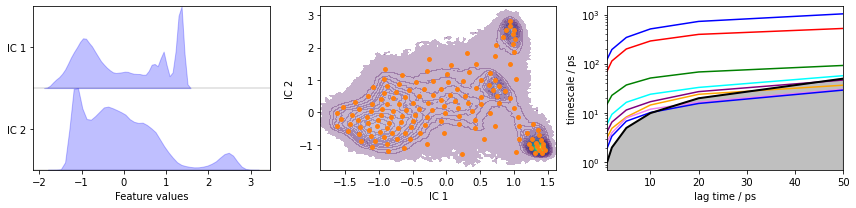

In [8]:
its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales)#, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()

In [9]:
counts = TCE(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs).submodel_largest()

fraction of states used = 1.000000
fraction of counts used = 1.000000


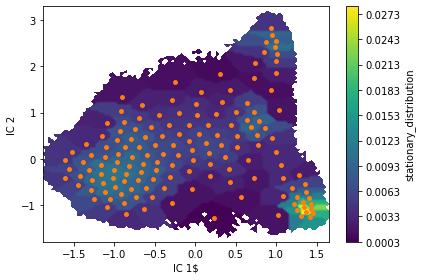

In [10]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(counts).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[np.concatenate(dtrajs)],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('IC 1$')
ax.set_ylabel('IC 2')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999997469, max=1.0000000000000424)


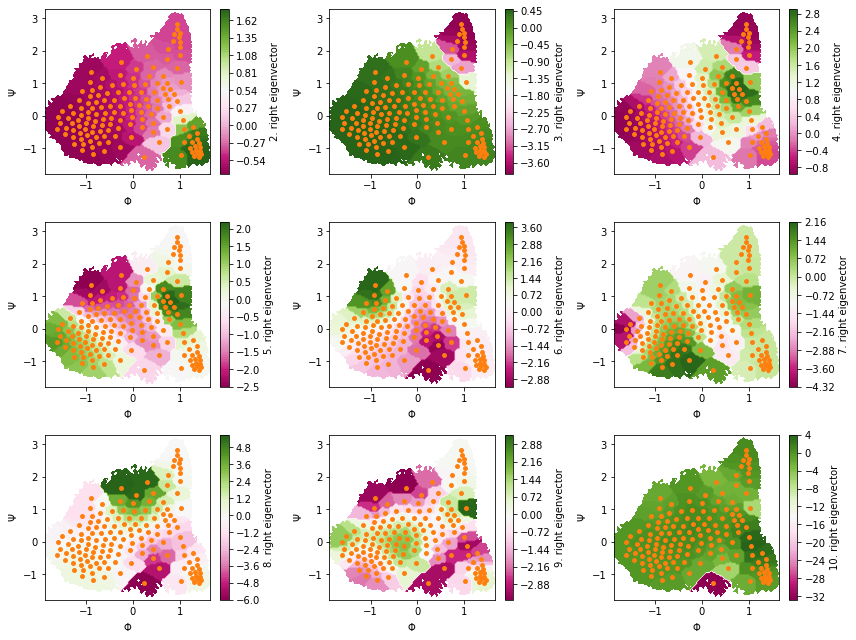

In [11]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[np.concatenate(dtrajs), i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

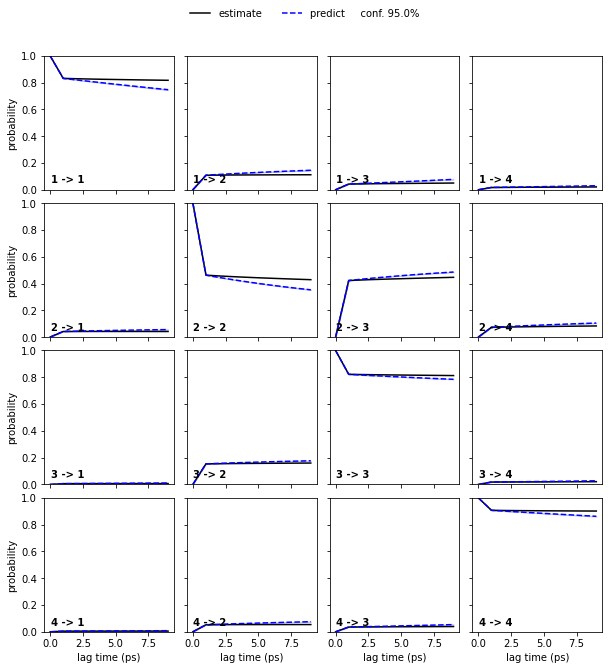

In [12]:
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [13]:
stats = bayesian_msm.gather_stats('timescales', k=num_timescales)
sample_mean = stats.mean
sample_conf_l, sample_conf_r = stats.L, stats.R

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
real_sample_mean = sample_mean
real_sample_conf_l = sample_conf_l
real_sample_conf_r = sample_conf_r

Mean of ITS #0: 122.837079
Confidence interval of ITS #0: [120.101334, 125.887942]
Mean of ITS #1: 71.060094
Confidence interval of ITS #1: [69.023626, 73.296642]
Mean of ITS #2: 15.264179
Confidence interval of ITS #2: [15.082451, 15.531350]
Mean of ITS #3: 5.964660
Confidence interval of ITS #3: [5.927015, 6.002338]
Mean of ITS #4: 4.169787
Confidence interval of ITS #4: [4.139212, 4.204736]
Mean of ITS #5: 3.183595
Confidence interval of ITS #5: [3.165731, 3.204461]
Mean of ITS #6: 2.601137
Confidence interval of ITS #6: [2.574573, 2.631428]
Mean of ITS #7: 1.974131
Confidence interval of ITS #7: [1.920934, 2.264182]


In [14]:
evec_real = eigvec
dtrajs_real = dtrajs
projected_data_real = projected_data

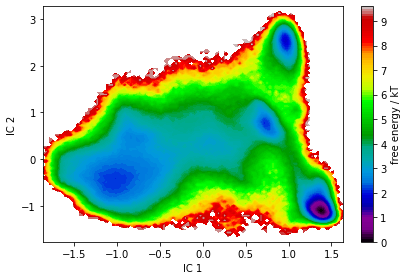

In [15]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_real).T[0]
IC_1 = np.concatenate(projected_data_real).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

plt.tight_layout()
plt.show()

# Fake

In [16]:
pdb = fake_top_fname
files = fake_trj_fname

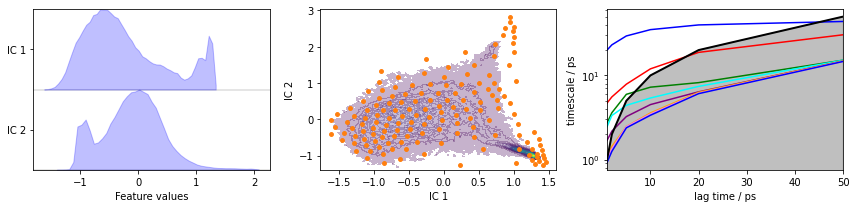

In [17]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Ca())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data = [d for d in data if d.shape[0] > lagtime]

#tica_estimator = dt.decomposition.TICA(lagtime=lagtime, dim=2)
#tica = tica_estimator.fit(data).fetch_model()

projected_data = [tica.transform(traj) for traj in data]

#cluster = dt.clustering.KMeans(150, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales)#, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()

In [18]:
counts_effective = TCE(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs).submodel_largest()
counts_sliding = TCE(lagtime=lagtime, count_mode='sliding').fit_fetch(dtrajs).submodel(counts_effective.state_symbols)

In [19]:
proj_dtrajs = counts_sliding.transform_discrete_trajectories_to_submodel(dtrajs)
proj_dtrajs_cc = np.concatenate(proj_dtrajs)
proj_dtrajs_cc = proj_dtrajs_cc[proj_dtrajs_cc >= 0]  # only use this for plotting

fraction of states used = 0.880000
fraction of counts used = 1.000000


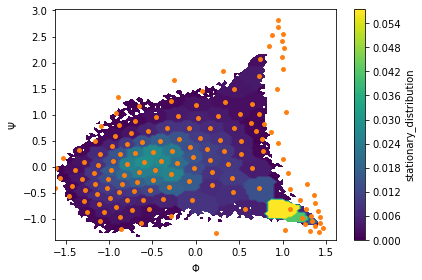

In [20]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(counts_sliding).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[proj_dtrajs_cc],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999919, max=1.000000000000024)


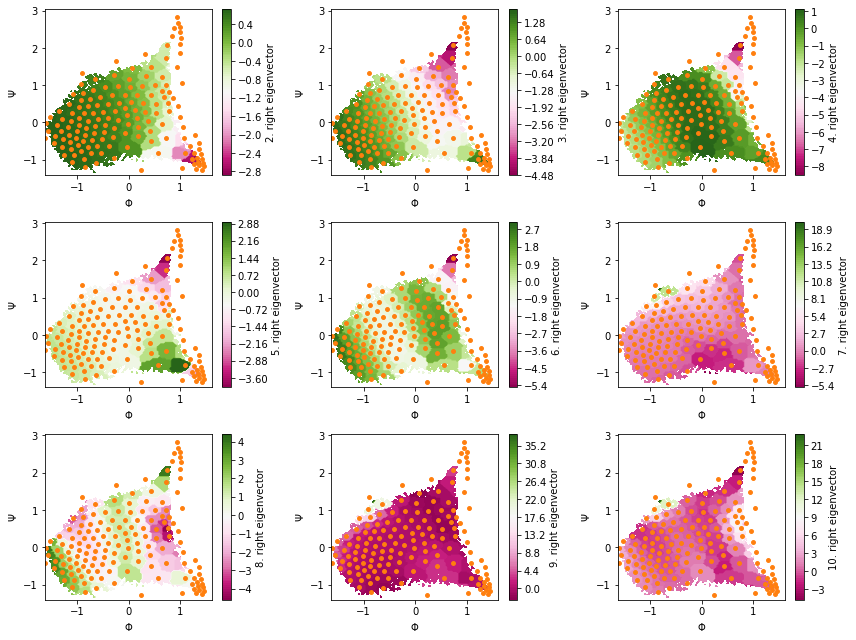

In [21]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[proj_dtrajs_cc, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

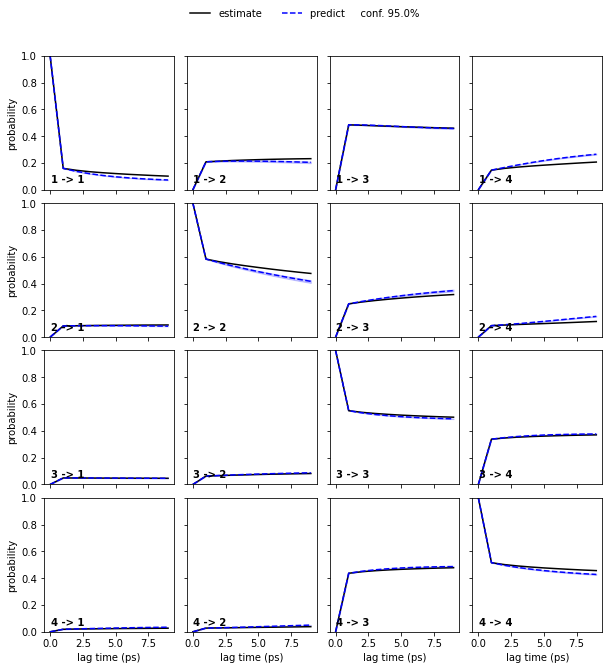

In [22]:
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts_effective).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [23]:
stats = bayesian_msm.gather_stats('timescales', k=num_timescales)
sample_mean = stats.mean
sample_conf_l, sample_conf_r = stats.L, stats.R

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
fake_sample_mean = sample_mean
fake_sample_conf_l = sample_conf_l
fake_sample_conf_r = sample_conf_r

Mean of ITS #0: 19.221865
Confidence interval of ITS #0: [18.223082, 20.119263]
Mean of ITS #1: 4.715342
Confidence interval of ITS #1: [4.632903, 4.829100]
Mean of ITS #2: 2.742439
Confidence interval of ITS #2: [2.665836, 2.845934]
Mean of ITS #3: 2.506045
Confidence interval of ITS #3: [2.430923, 2.595909]
Mean of ITS #4: 1.697701
Confidence interval of ITS #4: [1.671980, 1.729625]
Mean of ITS #5: 1.088597
Confidence interval of ITS #5: [1.062024, 1.189620]
Mean of ITS #6: 1.047488
Confidence interval of ITS #6: [1.037374, 1.062210]
Mean of ITS #7: 0.944012
Confidence interval of ITS #7: [0.906208, 1.021636]


In [24]:
evec_fake = eigvec
dtrajs_fake = dtrajs
projected_data_fake = projected_data

In [25]:
#coords = pyemma.coordinates.load(fake_trj_fname, top=fake_top_fname)
#coords = [d for d in coords if d.shape[0] > lagtime]

In [27]:
#coords_cc=  np.concatenate(coords).reshape(200000, -1, 3)
#coords_cc.shape

(200000, 175, 3)

In [28]:
#trj_test = md.load(fake_top_fname)
#trj_test.xyz = coords_cc
#trj_test.time = np.arange(coords_cc.shape[0])

In [29]:
#_, phi_fake = md.compute_phi(trj_test)
#_, psi_fake = md.compute_psi(trj_test)
#_, omega_fake = md.compute_omega(trj_test)

In [31]:
#coords = pyemma.coordinates.load(real_trj_fname, top=real_top_fname)
#coords = [d for d in coords if d.shape[0] > lagtime]

In [ ]:
#coords_real=  np.concatenate(coords).reshape(1868861, -1, 3)
#coords_real.shape

In [ ]:
#trj_real = md.load(real_top_fname)
#trj_real.xyz = coords_real
#trj_real.time = np.arange(coords_real.shape[0])

In [ ]:
#_, phi_real = md.compute_phi(trj_real)
#_, psi_real = md.compute_psi(trj_real)
#_, omega_real = md.compute_omega(trj_real)

In [ ]:
#fig, ax = plt.subplots(3, 3, figsize=(15, 10))

#ax = ax.flatten()

#for i, axes in enumerate(ax):
#    bins = np.linspace(phi_real[:, i].min(), phi_real[:, i].max(), 50)
#    axes.hist(phi_real[:, i], bins=bins, label='Real', density=True, alpha=0.75)
#    axes.hist(phi_fake[:, i], bins=bins, label='Fake', density=True, alpha=0.75)
#    axes.set_title(f'$\phi_{i}$', fontsize=16)
#    axes.legend()
#plt.tight_layout()

In [ ]:
#fig, ax = plt.subplots(3, 3, figsize=(15, 10))

#ax = ax.flatten()

#for i, axes in enumerate(ax):
#    bins = np.linspace(psi_real[:, i].min(), psi_real[:, i].max(), 50)
#    axes.hist(psi_real[:, i], bins=bins, label='Real', density=True, alpha=0.75)
#    axes.hist(psi_fake[:, i], bins=bins, label='Fake', density=True, alpha=0.75)
#    axes.set_title(f'$\psi_{i}$', fontsize=16)
#    axes.legend()
#plt.tight_layout()

In [ ]:
#fig, ax = plt.subplots(3, 3, figsize=(15, 10))

#ax = ax.flatten()

#for i, axes in enumerate(ax):
#    bins = np.linspace(omega_real[:, i].min(), omega_real[:, i].max(), 50)
#    axes.hist(omega_real[:, i], bins=bins, label='Real', density=True, alpha=0.75)
#    axes.hist(omega_fake[:, i], bins=bins, label='Fake', density=True, alpha=0.75)
#    axes.set_title(f'$\omega_{i}$', fontsize=16)
#    axes.legend()
#plt.tight_layout()

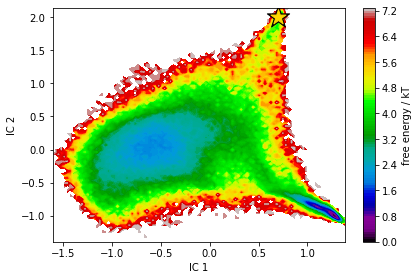

In [26]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_fake).T[0]
IC_1 = np.concatenate(projected_data_fake).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
#plt.scatter([-0.5], [0], marker='*', s=250, color='red')
#plt.scatter([1.25], [-1], marker='*', s=250, color='red')

point = [0.7, 2.0]
plt.scatter([point[0]], [point[1]], marker='*', s=550, color='black')
plt.scatter([point[0]], [point[1]], marker='*', s=250, color='gold')




plt.tight_layout()
plt.show()

In [32]:
coords = pyemma.coordinates.load(fake_trj_fname, top=fake_top_fname)
coords = [d for d in coords if d.shape[0] > lagtime]

coords_cc=  np.concatenate(coords).reshape(200000, -1, 3)
coords_cc.shape

(200000, 175, 3)

In [33]:
#point = [-0.5, 0]
#point = [1.25, -1]
point = [0.7, 2.0]
idxs = np.argsort(np.sum((np.concatenate(projected_data_fake) - np.array(point))**2, 1))

In [34]:
trj_test = md.load(fake_top_fname)

In [35]:
trj_test.xyz = coords_cc[idxs][:25]
trj_test.time = np.arange(25)

In [36]:
trj_test = trj_test.superpose(trj_test)

In [38]:
v = nv.show_mdtraj(trj_test[0])
for frame in trj_test[1:]:
    v.add_trajectory(nv.MDTrajTrajectory(frame))
v

NGLWidget()

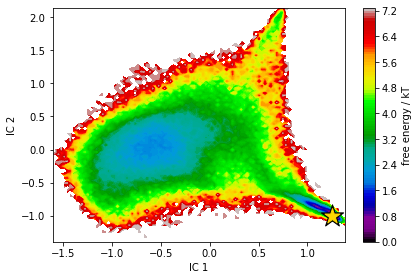

In [39]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_fake).T[0]
IC_1 = np.concatenate(projected_data_fake).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
#plt.scatter([-0.5], [0], marker='*', s=250, color='red')
#plt.scatter([1.25], [-1], marker='*', s=250, color='red')

point = [1.25, -1]
plt.scatter([point[0]], [point[1]], marker='*', s=550, color='black')
plt.scatter([point[0]], [point[1]], marker='*', s=250, color='gold')




plt.tight_layout()
plt.show()

In [ ]:
coords = pyemma.coordinates.load(fake_trj_fname, top=fake_top_fname)
coords = [d for d in coords if d.shape[0] > lagtime]

coords_cc=  np.concatenate(coords).reshape(200000, -1, 3)
coords_cc.shape

In [40]:
#point = [-0.5, 0]
point = [1.25, -1]
#point = [0.7, 2.0]
idxs = np.argsort(np.sum((np.concatenate(projected_data_fake) - np.array(point))**2, 1))

In [41]:
trj_test = md.load(fake_top_fname)
trj_test.xyz = coords_cc[idxs][:25]
trj_test.time = np.arange(25)
trj_test = trj_test.superpose(trj_test)

In [42]:
v = nv.show_mdtraj(trj_test[0])
for frame in trj_test[1:]:
    v.add_trajectory(nv.MDTrajTrajectory(frame))
v

NGLWidget()

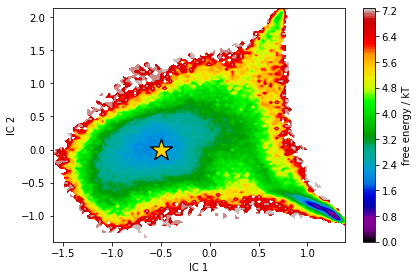

In [43]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_fake).T[0]
IC_1 = np.concatenate(projected_data_fake).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
#plt.scatter([-0.5], [0], marker='*', s=250, color='red')
#plt.scatter([1.25], [-1], marker='*', s=250, color='red')

point = [-0.5, 0]
plt.scatter([point[0]], [point[1]], marker='*', s=550, color='black')
plt.scatter([point[0]], [point[1]], marker='*', s=250, color='gold')




plt.tight_layout()
plt.show()

In [44]:
coords = pyemma.coordinates.load(fake_trj_fname, top=fake_top_fname)
coords = [d for d in coords if d.shape[0] > lagtime]

coords_cc=  np.concatenate(coords).reshape(200000, -1, 3)
coords_cc.shape

(200000, 175, 3)

In [45]:
#point = [-0.5, 0]
#point = [1.25, -1]
#point = [0.7, 2.0]
idxs = np.argsort(np.sum((np.concatenate(projected_data_fake) - np.array(point))**2, 1))

In [46]:
trj_test = md.load(fake_top_fname)
trj_test.xyz = coords_cc[idxs][:25]
trj_test.time = np.arange(25)
trj_test = trj_test.superpose(trj_test)

In [47]:
v = nv.show_mdtraj(trj_test[0])
for frame in trj_test[1:]:
    v.add_trajectory(nv.MDTrajTrajectory(frame))
v

NGLWidget()

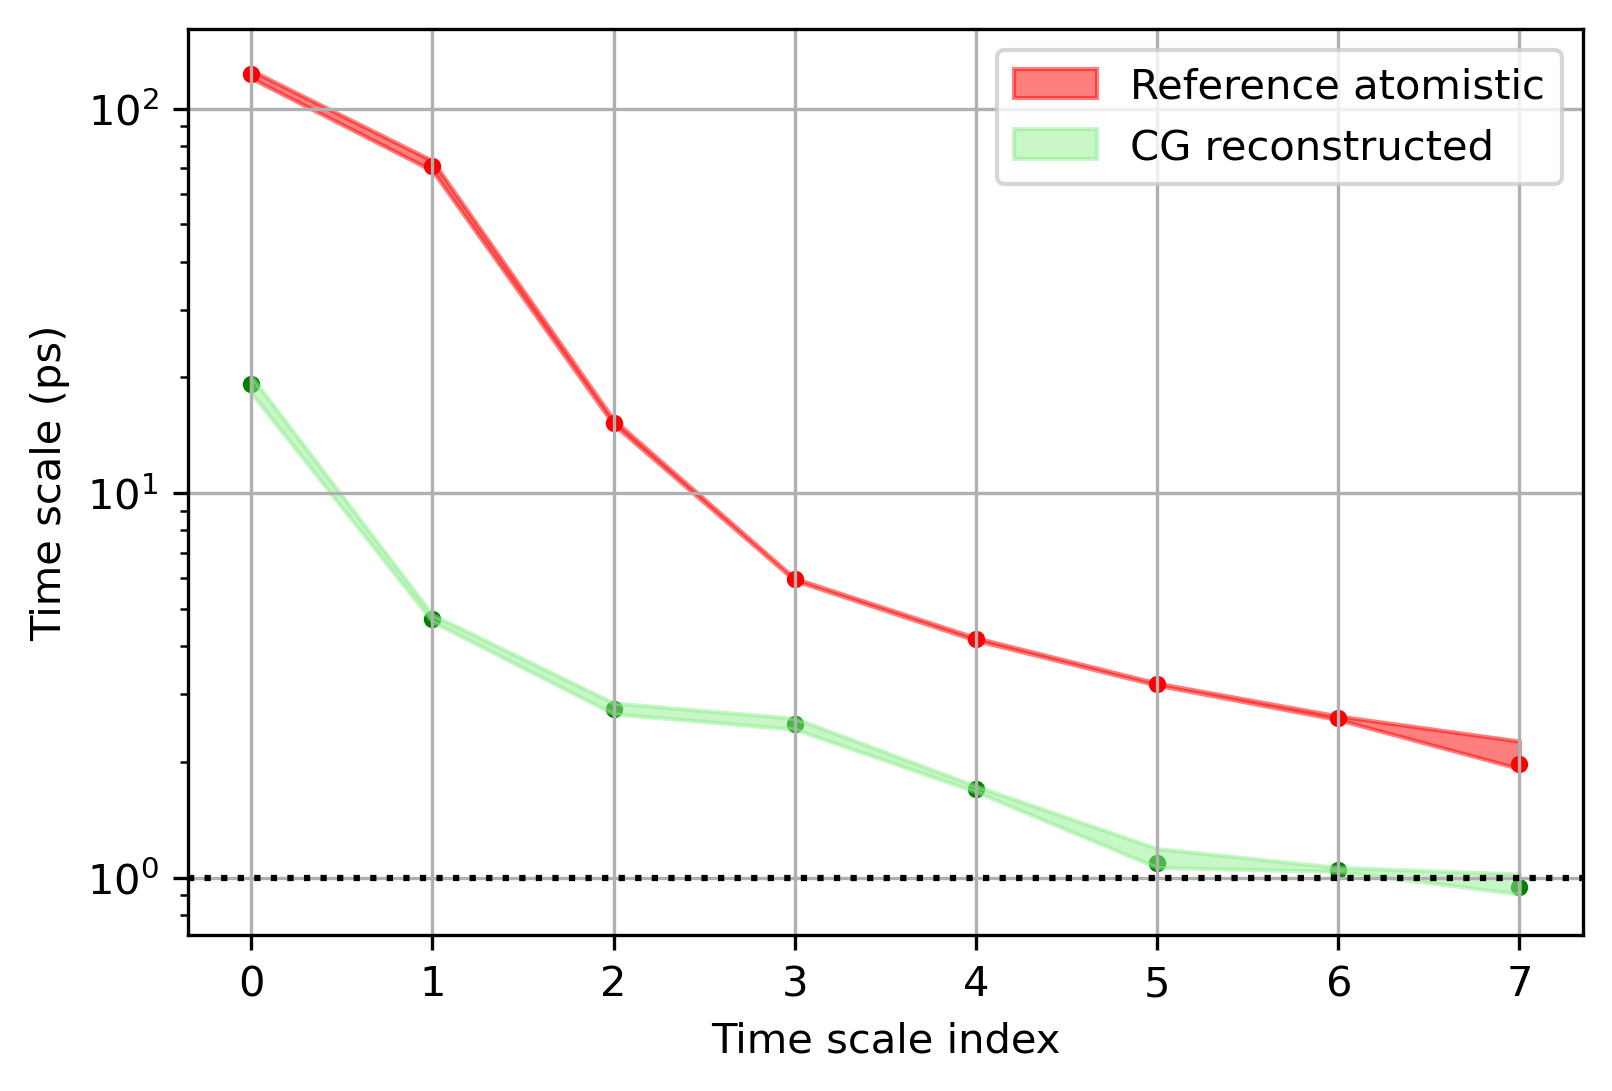

In [48]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Reference atomistic')
plt.yscale('log')

m = fake_sample_mean
r =  fake_sample_conf_r
l =  fake_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='CG reconstructed')
plt.yscale('log')

plt.axhline(lagtime, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (ps)')
plt.show()

In [49]:
scores = list()
for ts in tqdm(range(1, num_timescales+1)):
    scores.append(abs(1 - cosine(evec_real[:, ts][counts_sliding.state_symbols], evec_fake[:, ts])))    

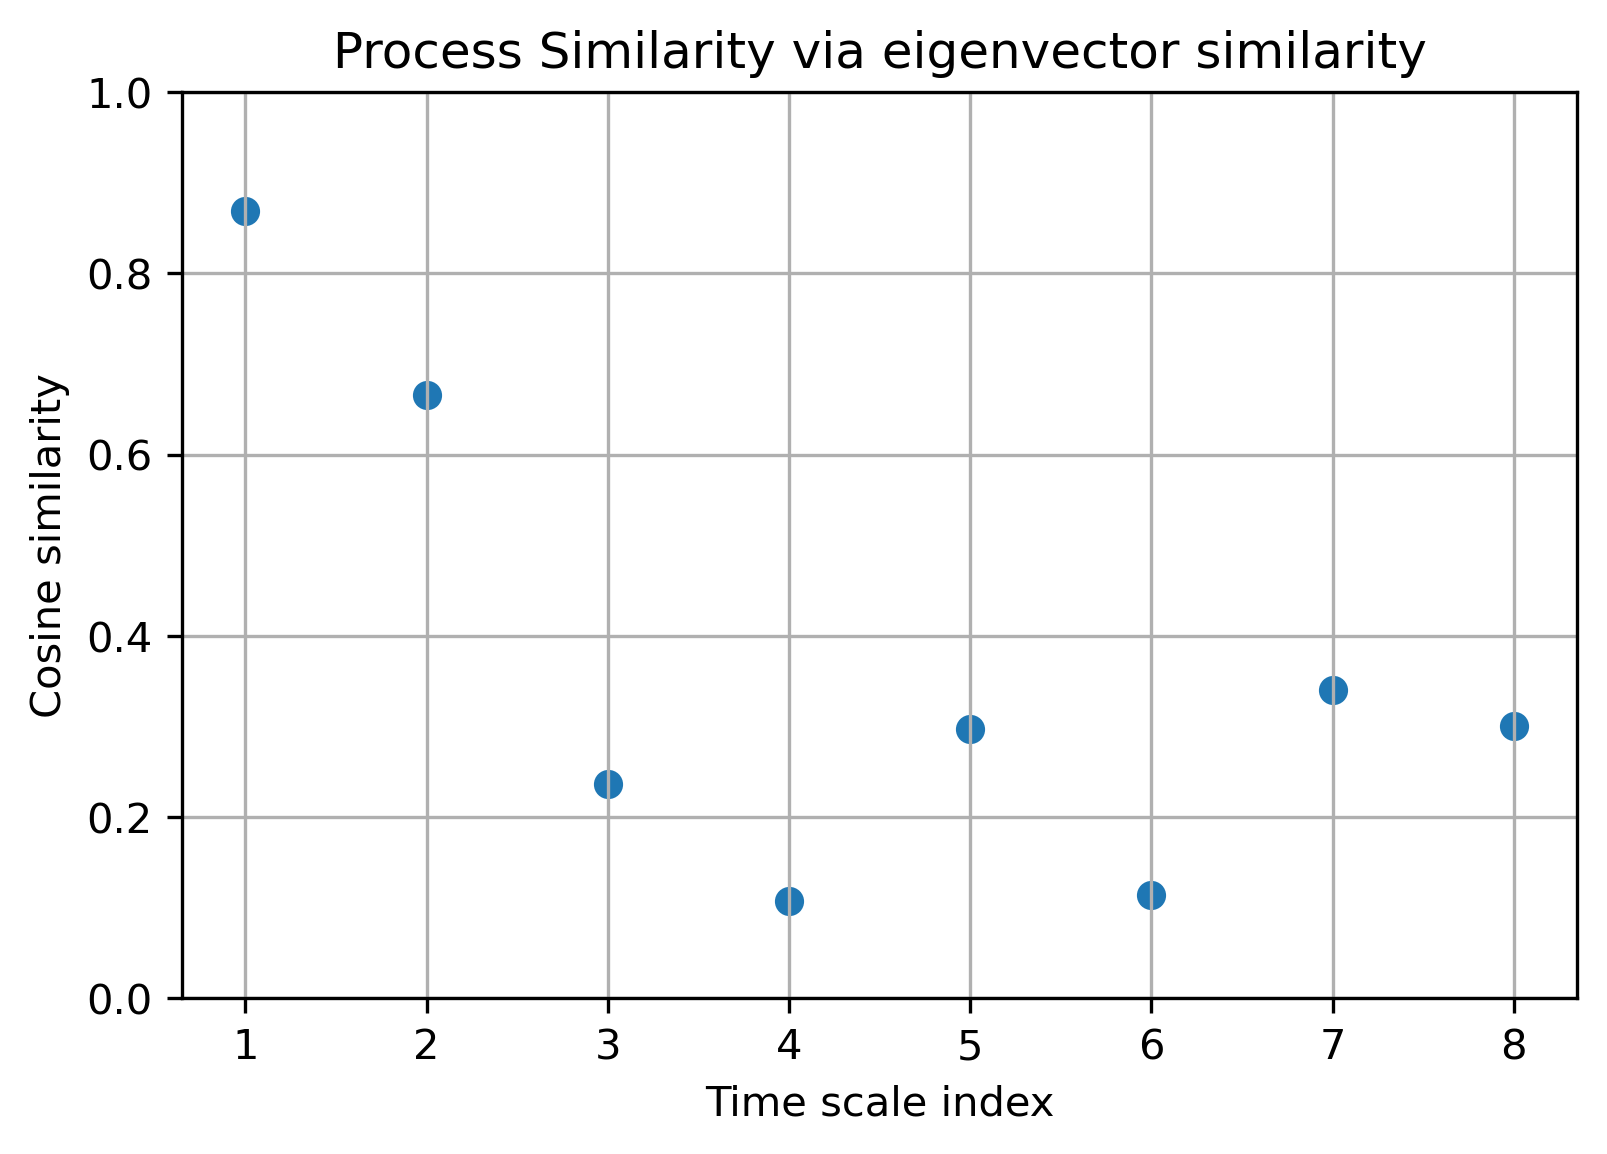

In [50]:
plt.figure(dpi=300)
plt.scatter(range(1, len(scores) + 1), scores)
plt.grid()
plt.xlabel('Time scale index')
plt.ylabel('Cosine similarity')
plt.title('Process Similarity via eigenvector similarity')
plt.ylim(0, 1)
plt.show()